# Object shape model - estimation

In [1]:
%matplotlib inline
import os, sys, glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pylab as plt
from scipy import ndimage

In [2]:
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import segmentation.utils.data_io as tl_io
import segmentation.region_growing as tl_rg
import segmentation.descriptors as tl_fts

## Loading ovary

In [5]:
COLORS = 'bgrmyck'
PATH_IMAGES = tl_io.update_path(os.path.join('images', 'drosophila_ovary_slice'), absolute=True)
PATH_DATA = tl_io.update_path('data', absolute=True)
PATH_OUT = tl_io.update_path('output', absolute=True)
print ([os.path.basename(p) for p in glob.glob(os.path.join(PATH_IMAGES, '*')) if os.path.isdir(p)])
dir_annot = os.path.join(PATH_IMAGES, 'annot_eggs')
# dir_annot = os.path.expanduser('~/Dropbox/Workspace/segment_Medical/Ovary-eggs/mask_2d_slice_complete_ind_egg')

['annot_eggs', 'annot_struct', 'center_levels', 'image', 'segm', 'segm_rgb']


### Loading...

In [6]:
list_paths = sorted(glob.glob(os.path.join(dir_annot, '*.png')))
print ('nb images:', len(list_paths), 'SAMPLES:', [os.path.basename(p) for p in list_paths[:5]])
list_segms = []
for path_seg in list_paths:
    seg = np.array(Image.open(path_seg))
    list_segms.append(seg)

nb images: 67 SAMPLES: ['insitu14807.png', 'insitu14808.png', 'insitu14809.png', 'insitu14810.png', 'insitu14811.png']


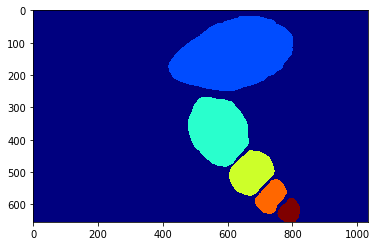

In [5]:
seg = list_segms[np.random.randint(0, len(list_segms))]
_= plt.imshow(seg, cmap=plt.cm.jet)

## Compute model

In [7]:
list_rays, list_shifts = tl_rg.compute_object_shapes(list_segms, ray_step=10, interp_order='spline', smooth_coef=1)
print ('nb eggs:', len(list_rays), 'nb rays:', len(list_rays[0]))

nb eggs: 241 nb rays: 36


In [8]:
fig = plt.figure(figsize=(8, 5))
x_axis = np.linspace(0, 360, len(list_rays[0]), endpoint=False)
plt.plot(x_axis, np.array(list_rays).T, '-')
plt.grid(), plt.xlim([0, 350])
plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')
fig.savefig(os.path.join(PATH_OUT, 'shape-rays_all.pdf'), bbox_inches='tight')

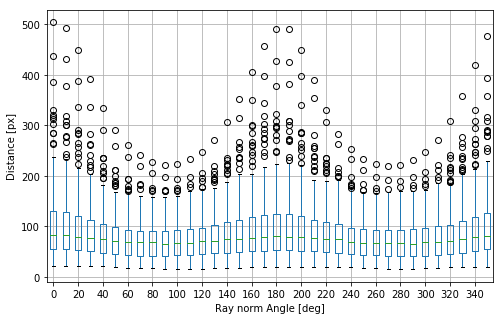

In [9]:
df = pd.DataFrame(np.array(list_rays), columns=x_axis.astype(int))
df.to_csv(os.path.join(PATH_DATA, 'egg_ray_shapes.csv'))

df.plot.box(figsize=(8, 5), grid=True)
plt.plt.xticks(range(1, 37, 2), [str(i * 10) for i in range(0, 36, 2)])
plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')
plt.savefig(os.path.join(PATH_OUT, 'shape-rays_statistic.pdf'), bbox_inches='tight')

## Clustering

In [9]:
df = pd.DataFrame().from_csv(os.path.join(PATH_DATA, 'egg_ray_shapes.csv'))
list_rays = df.values

### Spectral Clustering

In [11]:
from sklearn import cluster

model = cluster.SpectralClustering(10)
model.fit(np.array(list_rays))
print (np.bincount(model.labels_))

list_ray_core = []
for lb in np.unique(model.labels_):
    mean_rays = np.mean(np.asarray(list_rays)[model.labels_ == lb], axis=0)
    mean_rays = ndimage.filters.gaussian_filter1d(mean_rays, 1)
    list_ray_core.append(mean_rays)

[181   2   2   2   2   2  18   1  20  11]


/usr/local/lib/python3.5/dist-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(<matplotlib.text.Text at 0x7f04e651d668>,
 <matplotlib.text.Text at 0x7f04e60b29e8>)

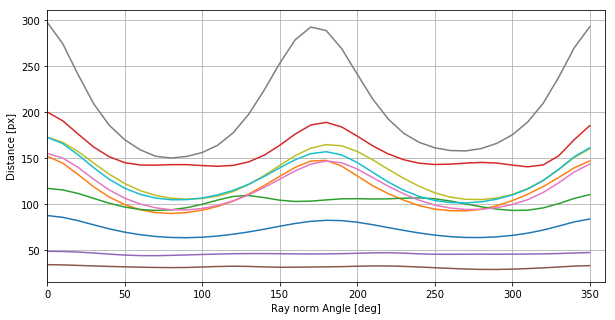

In [12]:
fig = plt.figure(figsize=(10, 5))
plt.plot(x_axis, np.array(list_ray_core).T, '-')
plt.grid(), plt.xlim([0, 360])
plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')

### Mean Shift

In [13]:
from sklearn import cluster

mean_shift = cluster.MeanShift()
mean_shift.fit(np.array(list_rays))
print (np.bincount(mean_shift.labels_))

[176  12   1   1  50   1]


(<matplotlib.text.Text at 0x7f04e611d470>,
 <matplotlib.text.Text at 0x7f04e6114b00>)

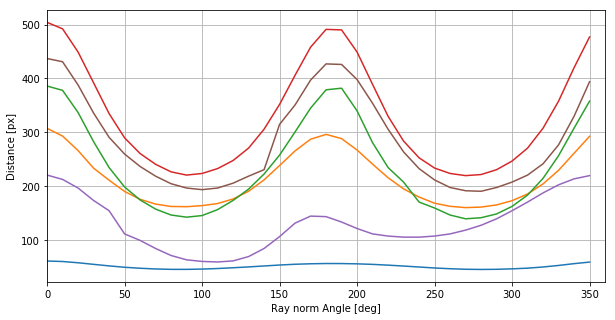

In [14]:
fig = plt.figure(figsize=(10, 5))
plt.plot(x_axis, mean_shift.cluster_centers_.T, '-')
plt.grid(), plt.xlim([0, 360])
plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')

### Gaussian Mixture Model

In [15]:
from sklearn import mixture

gmm = mixture.BayesianGaussianMixture(n_components=10)
gmm.fit(np.array(list_rays))
# gmm.fit(np.array(list_rays), mean_shift_labels)
print ('weights:', gmm.weights_, 'means:', gmm.means_.shape, 'covariances:', gmm.covariances_.shape)

weights: [ 0.16114933  0.09868214  0.03680146  0.1382247   0.16145643  0.11589703
  0.01182544  0.17488648  0.02245779  0.0786192 ] means: (10, 36) covariances: (10, 36, 36)


(<matplotlib.text.Text at 0x7f04e60b2550>,
 <matplotlib.text.Text at 0x7f04e60568d0>)

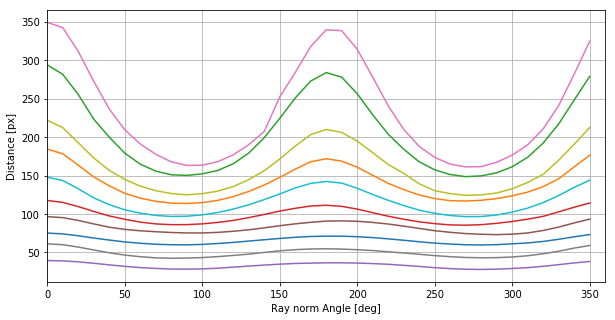

In [16]:
fig = plt.figure(figsize=(10, 5))
plt.plot(x_axis, gmm.means_.T, '-', label=' ')
plt.grid(), plt.xlim([0, 360])
plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')

### Agglomerative Clustering

In [17]:
agg = cluster.AgglomerativeClustering(7)
agg.fit(np.array(list_rays))
# gmm.fit(np.array(list_rays), mean_shift_labels)
print (np.bincount(agg.labels_))

list_ray_core = []
for lb in np.unique(model.labels_):
    mean_rays = np.mean(np.asarray(list_rays)[model.labels_ == lb], axis=0)
    mean_rays = ndimage.filters.gaussian_filter1d(mean_rays, 1)
    list_ray_core.append(mean_rays)

[13 84 58 29  2 38 17]


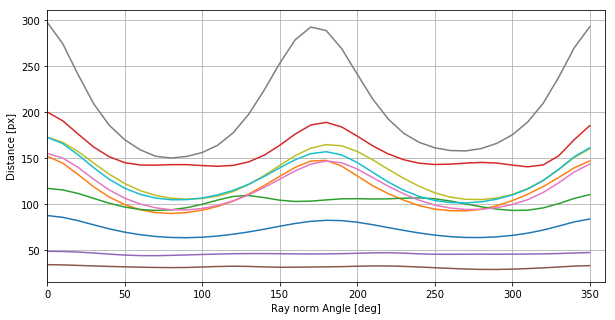

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(x_axis, np.array(list_ray_core).T, '-')
plt.grid(), plt.xlim([0, 360])
_= plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')

## Cumulativ Priors

In [10]:
df = pd.DataFrame().from_csv(os.path.join(PATH_DATA, 'egg_ray_shapes.csv'))
list_rays = df.values

In [11]:
def compute_prior_map(cdist, size=(500, 800), step=5):
    prior_map = np.zeros(size)
    centre = np.array(size) / 2
    for i in np.arange(prior_map.shape[0], step=step):
        for j in np.arange(prior_map.shape[1], step=step):
            prior_map[i:i+step, j:j+step] = \
                tl_rg.compute_shape_prior_table_cdf([i, j], cdist, centre, angle_shift=0)
    return prior_map

### Histogram

(<matplotlib.axes._subplots.AxesSubplot at 0x7f06d18dcda0>,
 <matplotlib.image.AxesImage at 0x7f06d04baa20>)

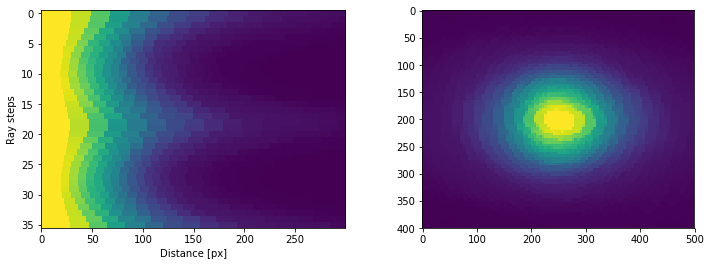

In [12]:
list_cdf = tl_rg.transform_rays_model_cdf_histograms(list_rays, nb_bins=25)
cdist = np.array(list_cdf)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1), plt.imshow(cdist[:, :300], aspect='auto'), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, size=(400, 500), step=5))

### Mixture model

[ 0.36767247  0.06156482  0.15077523  0.37937466  0.03307044  0.00754238]


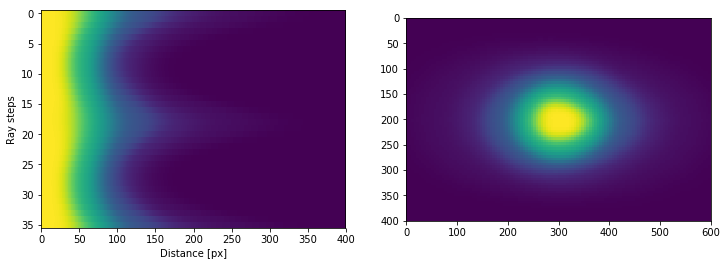

In [30]:
mm, list_cdf = tl_rg.transform_rays_model_cdf_mixture(list_rays, coef_components=1)
cdist = np.array(list_cdf)
print (mm.weights_)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1), plt.imshow(cdist[:, :], aspect='auto'), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, size=(400, 600), step=5))
# plt.savefig('shape-rays_gmm-cdf-proj.pdf')

### Spectral Clustering

[233   2   2   2   2]


/usr/local/lib/python3.5/dist-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(<matplotlib.axes._subplots.AxesSubplot at 0x7f04e5a65fd0>,
 <matplotlib.image.AxesImage at 0x7f04e6183630>)

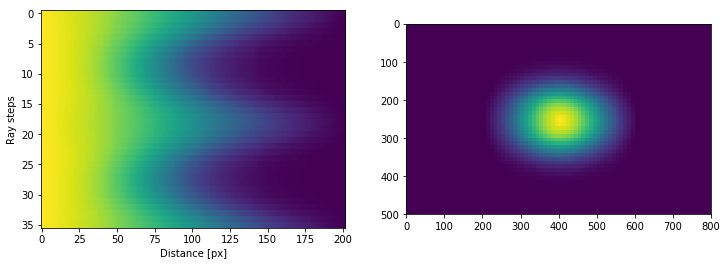

In [22]:
sc, list_cdf = tl_rg.transform_rays_model_cdf_spectral(list_rays)
cdist = np.array(list_cdf)
print (np.bincount(sc.labels_))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1), plt.imshow(cdist, aspect='auto'), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, step=10))

### K-means

[10 22  1  3 23  6 13 16  5  1 26 25 12  1  8  1 12 15  1  1  2 18  1  5 13]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f04e6191668>,
 <matplotlib.image.AxesImage at 0x7f04e857e1d0>)

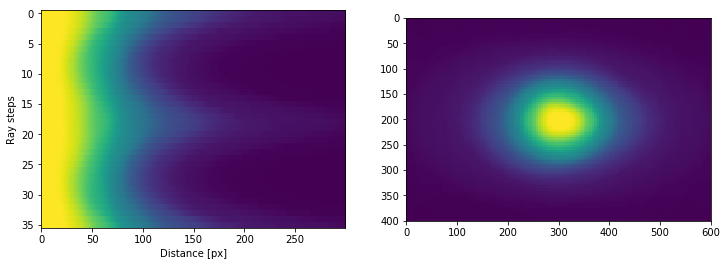

In [23]:
km, list_cdf = tl_rg.transform_rays_model_cdf_kmeans(list_rays, 25)
cdist = np.array(list_cdf)
print (np.bincount(km.labels_))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1), plt.imshow(cdist[:, :300], aspect='auto'), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, size=(400, 600), step=5))

## Mixture of Cumulativ Models

In [13]:
df = pd.DataFrame().from_csv(os.path.join(PATH_DATA, 'egg_ray_shapes.csv'))
list_rays = df.values

### Gaussian mixture

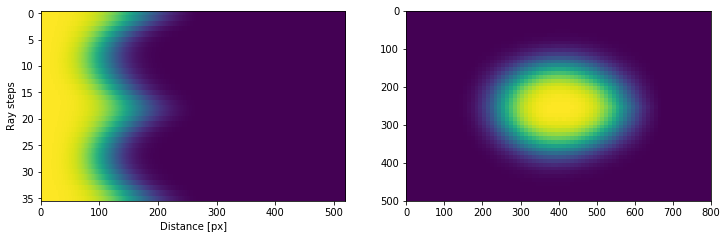

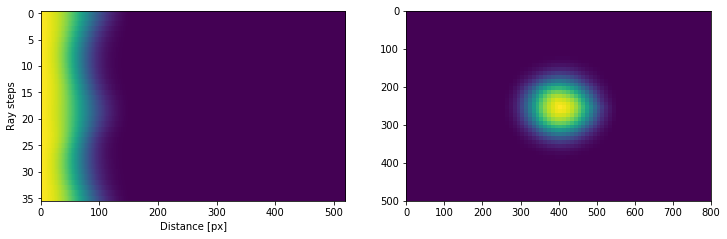

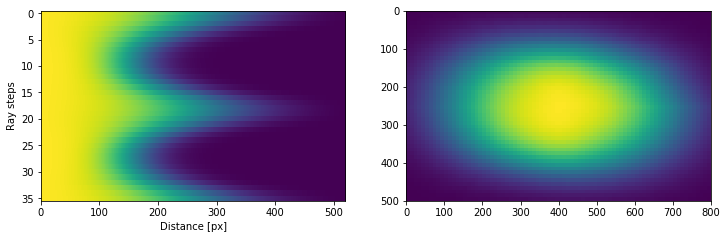

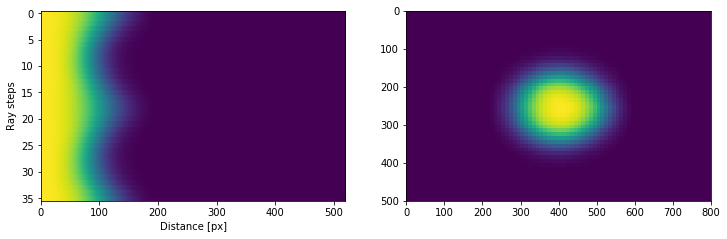

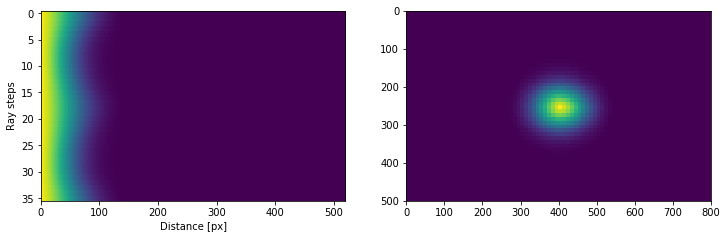

In [34]:
model, list_mean_cdf = tl_rg.transform_rays_model_sets_mean_cdf_mixture(list_rays, 5)
max_len = max([np.asarray(l_cdf).shape[1] for _, l_cdf in list_mean_cdf])

for i, (mean, list_cdf) in enumerate(list_mean_cdf):
    cdist = np.zeros((len(list_cdf), max_len))
    cdist[:, :len(list_cdf[0])] = np.array(list_cdf)
    plt.figure(figsize=(12, 3.5))
    plt.subplot(1, 2, 1), plt.imshow(cdist, aspect='auto'), plt.xlim([0, max_len]), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
    plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, step=10))
    # plt.savefig('shape-rays_gmm-cdf-proj_%i.pdf' % (i + 1))

### K-Means

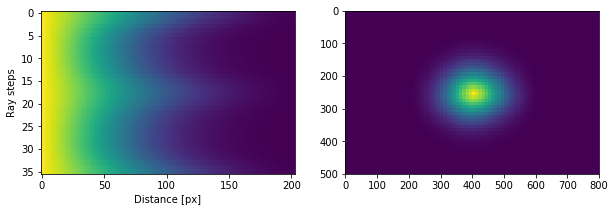

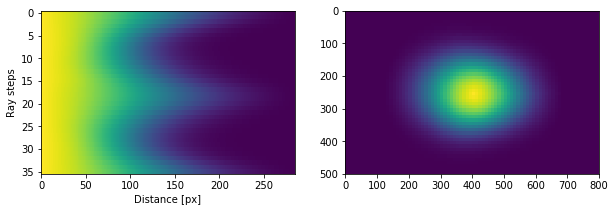

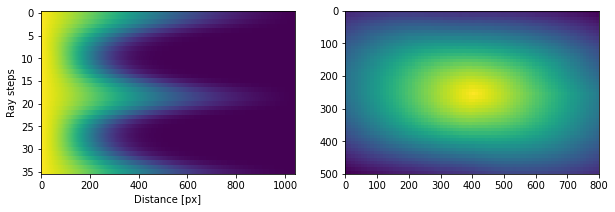

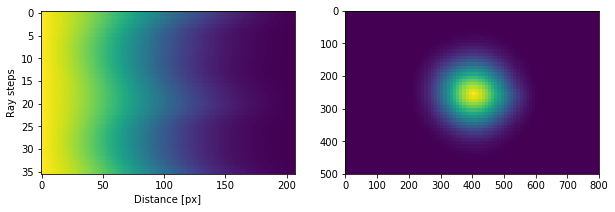

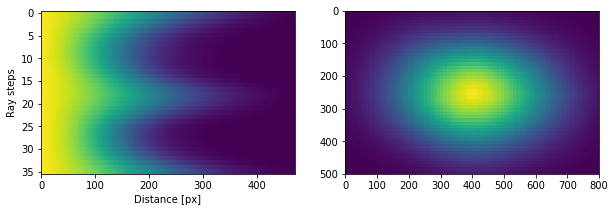

In [25]:
model, list_mean_cdf = tl_rg.transform_rays_model_sets_mean_cdf_kmeans(list_rays, 5)
max_len = max([np.asarray(l_cdf).shape[1] for _, l_cdf in list_mean_cdf])

for mean, list_cdf in list_mean_cdf:
    cdist = np.zeros((len(list_cdf), max_len))
    cdist[:, :len(list_cdf[0])] = np.array(list_cdf)
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1), plt.imshow(cdist, aspect='auto'), plt.xlim([0, max_len]), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
    plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, step=10))

## Show Shape prior with sample egg

In [26]:
seg_object = (seg == 2)
centre = ndimage.measurements.center_of_mass(seg_object)
ray = tl_fts.compute_ray_features_segm_2d(seg_object, centre, edge='down')
_, shift = tl_fts.shift_ray_features(ray)
print ('centre:', centre)
print ('angle shift:', shift)

centre: (371.27584962603333, 571.34372129641781)
angle shift: 240.0


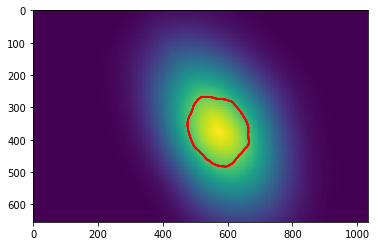

In [27]:
prior_map = np.zeros(seg_object.shape)
error_pos = []
for i in np.arange(prior_map.shape[0], step=5):
    for j in np.arange(prior_map.shape[1], step=5):
        prior_map[i:i+5, j:j+5] = tl_rg.compute_shape_prior_table_cdf([i, j], cdist, centre, angle_shift=shift)

_= plt.imshow(prior_map), plt.contour(seg_object, colors='r')